In [1]:
%%html
<style>#notebook-container{width: 90%;}</style>

In [2]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from pathlib import Path

In [3]:
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (18, 10)
palette = sns.color_palette()

In [4]:
def auc(train_sizes, valid_scores):
    x = (train_sizes - train_sizes.min()) / (train_sizes.max() - train_sizes.min())
    dx, dy = (np.diff(array) for array in (x, valid_scores))
    y0 = valid_scores[:-1]
    return (dx * y0 + .5 * dx * dy).sum()

In [5]:
with open("../grabo/gs_lstm_128/gs_results.json") as jsonfile:
    results = pd.DataFrame.from_dict(json.load(jsonfile)["cv_results"])

results = pd.concat([
    pd.DataFrame(results["params"].tolist()),
    results.drop(["params", "train_sizes", "train_scores", "test_scores"], axis=1), 
    pd.DataFrame(results["train_sizes"].tolist(), columns=list(map("split{}_size".format, range(5)))),
    pd.DataFrame(results["train_scores"].tolist(), columns=list(map("split{}_train_score".format, range(5)))),
    pd.DataFrame(results["test_scores"].tolist(), columns=list(map("split{}_test_score".format, range(5)))),
], axis=1)
results.set_index(list(results.columns[:6]), inplace=True)
results.columns = pd.MultiIndex.from_tuples(list(map(lambda col: col.split("_", maxsplit=1), results.columns)), names=["split", None])
results = results.stack(level=0).reset_index()
results = pd.concat([
    results.drop(["train_score", "test_score", "split"], axis=1),
    pd.DataFrame(results["train_score"].tolist(), columns=list(map("cv{}_train_score".format, range(3)))),
    pd.DataFrame(results["test_score"].tolist(), columns=list(map("cv{}_test_score".format, range(3)))),
], axis=1)
results.set_index(list(results.columns[:7]), inplace=True)
results.columns = pd.MultiIndex.from_tuples(list(map(lambda col: col.split("_", maxsplit=1), results.columns)), names=["cv", None])
results = results.stack(level=0).reset_index()
results["split"]  = results["cv"].str.replace("cv", "").astype(int)
results.drop(["cv", "auc_train_score", "auc_test_score"], axis=1, inplace=True)
results.set_index(["hidden_dim", "num_layers", "dropout", "rnn_type", "size", "split"], inplace=True)
curves = results["test_score"].unstack("size")
auc_scores = curves.apply(lambda row: auc(row.index, row.values), axis=1).groupby(level=[0,1,2,3]).agg(["mean", "std"])

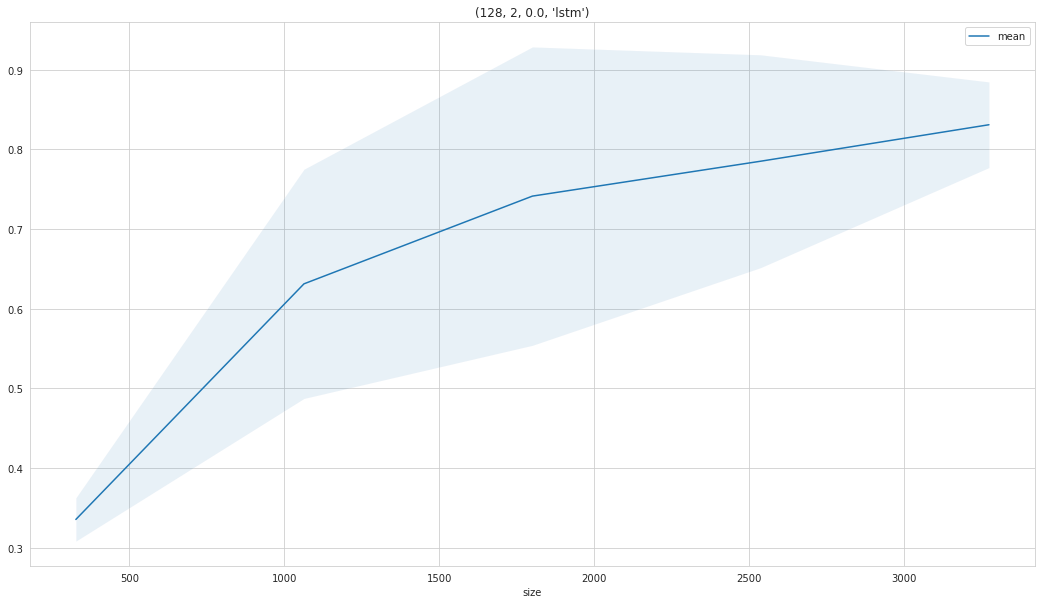

In [6]:
best_curve = curves.groupby(level=[0,1,2,3]).agg(["mean", "std"]).loc[auc_scores.sort_values("mean").tail(1).index].stack(level=0).reset_index().set_index(["hidden_dim", "num_layers", "dropout", "rnn_type"]).rename(columns={"level_4": "size"})
ax = best_curve.plot(x="size", y="mean")
ax.fill_between(best_curve["size"], best_curve["mean"] - 1.96 * best_curve["std"], best_curve["mean"] + 1.96 * best_curve["std"], alpha=.1)
ax.set_title(*best_curve.head(1).index);

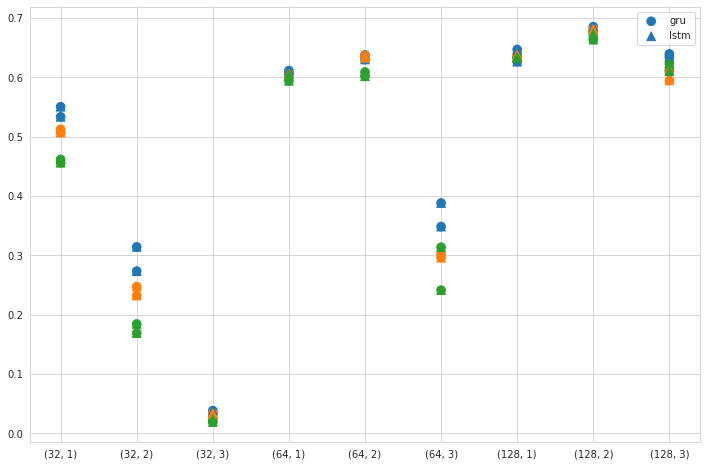

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
for rnn_type, marker in [("gru", "o"), ("lstm", "^")]:
    view = auc_scores[auc_scores.index.get_loc_level(rnn_type, level="rnn_type")[0]]
    ax.scatter(
        x=list(map(str, map(tuple, auc_scores.reset_index()[["hidden_dim", "num_layers"]].values))), 
        y=auc_scores["mean"],
        c=auc_scores.index.get_level_values("dropout").map(lambda x: palette[int(x*10)]),
        marker=marker,
        s=75,
        label=rnn_type
    )

ax.legend();

In [8]:
df = auc_scores.reset_index()
df = df.assign(rnn_type=df["rnn_type"].map(["gru", "lstm"].index), hidden_dim=np.log2(df.hidden_dim))
model = sm.OLS(df["mean"], df.iloc[:, :4])
res = model.fit()
print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:                   mean   R-squared (uncentered):                   0.955
Model:                            OLS   Adj. R-squared (uncentered):              0.951
Method:                 Least Squares   F-statistic:                              265.4
Date:                Thu, 17 Dec 2020   Prob (F-statistic):                    5.25e-33
Time:                        08:20:27   Log-Likelihood:                          42.626
No. Observations:                  54   AIC:                                     -77.25
Df Residuals:                      50   BIC:                                     -69.30
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [9]:
with open("../patience/gridsearch/gs_results.json") as jsonfile:
    results = pd.DataFrame.from_dict(json.load(jsonfile)["cv_results"])

results = pd.concat([
    pd.DataFrame(results["params"].tolist()),
    results.drop(["params", "train_sizes", "train_scores", "test_scores"], axis=1), 
    pd.DataFrame(results["train_sizes"].tolist(), columns=list(map("split{}_size".format, range(5)))),
    pd.DataFrame(results["train_scores"].tolist(), columns=list(map("split{}_train_score".format, range(5)))),
    pd.DataFrame(results["test_scores"].tolist(), columns=list(map("split{}_test_score".format, range(5)))),
], axis=1)
results.set_index(list(results.columns[:6]), inplace=True)
results.columns = pd.MultiIndex.from_tuples(list(map(lambda col: col.split("_", maxsplit=1), results.columns)), names=["split", None])
results = results.stack(level=0).reset_index()
results = pd.concat([
    results.drop(["train_score", "test_score", "split"], axis=1),
    pd.DataFrame(results["train_score"].tolist(), columns=list(map("cv{}_train_score".format, range(3)))),
    pd.DataFrame(results["test_score"].tolist(), columns=list(map("cv{}_test_score".format, range(3)))),
], axis=1)
results.set_index(list(results.columns[:7]), inplace=True)
results.columns = pd.MultiIndex.from_tuples(list(map(lambda col: col.split("_", maxsplit=1), results.columns)), names=["cv", None])
results = results.stack(level=0).reset_index()
results["split"]  = results["cv"].str.replace("cv", "").astype(int)
results.drop(["cv", "auc_train_score", "auc_test_score"], axis=1, inplace=True)
results.set_index(["hidden_dim", "num_layers", "dropout", "rnn_type", "size", "split"], inplace=True)
curves = results["test_score"].unstack("size")
auc_scores = curves.apply(lambda row: auc(row.index, row.values), axis=1).groupby(level=[0,1,2,3]).agg(["mean", "std"])

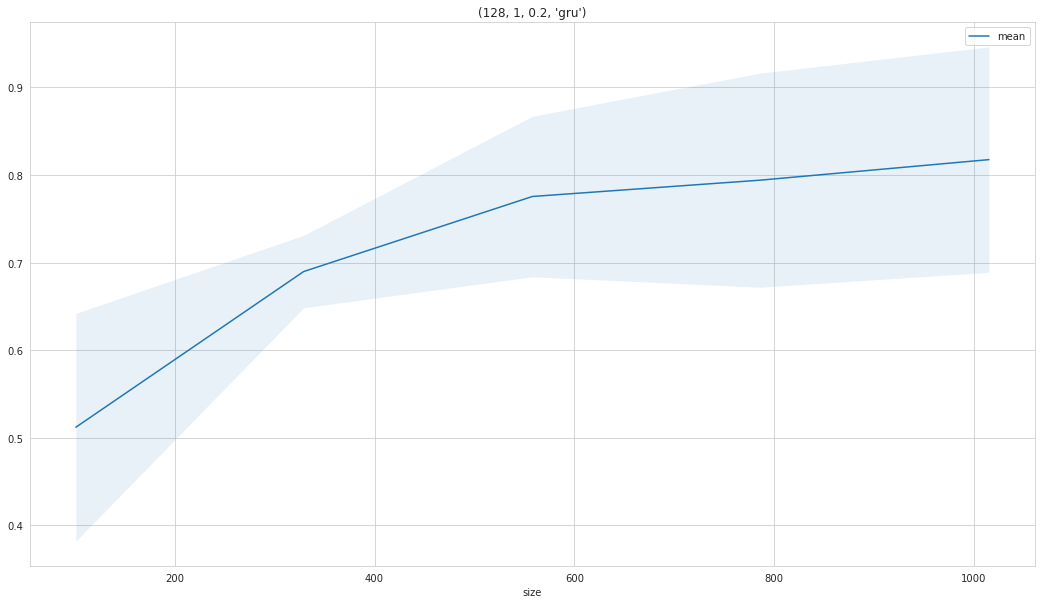

In [10]:
best_curve = curves.groupby(level=[0,1,2,3]).agg(["mean", "std"]).loc[auc_scores.sort_values("mean").tail(1).index].stack(level=0).reset_index().set_index(["hidden_dim", "num_layers", "dropout", "rnn_type"]).rename(columns={"level_4": "size"})
ax = best_curve.plot(x="size", y="mean")
ax.fill_between(best_curve["size"], best_curve["mean"] - 1.96 * best_curve["std"], best_curve["mean"] + 1.96 * best_curve["std"], alpha=.1)
ax.set_title(*best_curve.head(1).index);

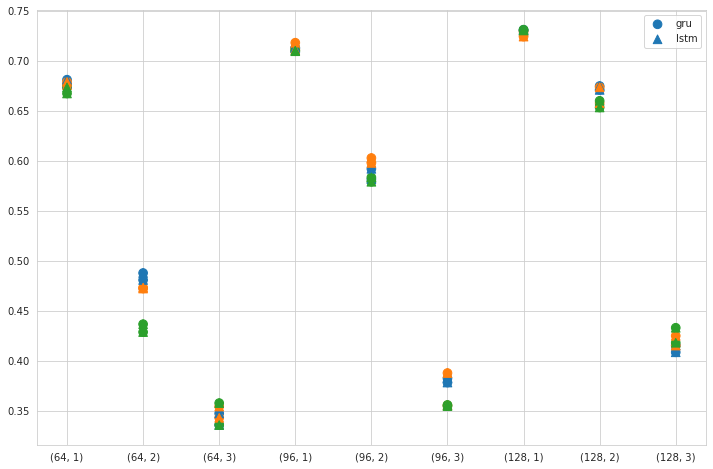

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
for rnn_type, marker in [("gru", "o"), ("lstm", "^")]:
    view = auc_scores[auc_scores.index.get_loc_level(rnn_type, level="rnn_type")[0]]
    ax.scatter(
        x=list(map(str, map(tuple, auc_scores.reset_index()[["hidden_dim", "num_layers"]].values))), 
        y=auc_scores["mean"],
        c=auc_scores.index.get_level_values("dropout").map(lambda x: palette[int(x*10)]),
        marker=marker,
        s=75,
        label=rnn_type
    )
    
ax.legend();

In [12]:
df = auc_scores.reset_index()
df = df.assign(rnn_type=df["rnn_type"].map(["gru", "lstm"].index), hidden_dim=np.log2(df.hidden_dim))
model = sm.OLS(df["mean"], df.iloc[:, :4])
res = model.fit()
print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:                   mean   R-squared (uncentered):                   0.996
Model:                            OLS   Adj. R-squared (uncentered):              0.996
Method:                 Least Squares   F-statistic:                              3431.
Date:                Thu, 17 Dec 2020   Prob (F-statistic):                    2.57e-60
Time:                        08:20:28   Log-Likelihood:                          105.35
No. Observations:                  54   AIC:                                     -202.7
Df Residuals:                      50   BIC:                                     -194.7
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------